## Init

In [3]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import random

In [2]:
base = os.path.basename(os.getcwd())
list = os.getcwd().split(os.sep) 
list.pop(list.index(base))
ROOT = '\\'.join(list)
DATA_PATH = os.path.join(ROOT, 'datasets\\preprocessed')

In [ ]:
import sys

path_to_networks = os.path.join(ROOT, 'scripts')
sys.path.append(path_to_networks)

from networks import Net_3layers, Net_5layers

In [3]:
# available datasets:
#   miRNA\\clinical_miRNA_normalized_log.csv
#   miRNA\\clinical_miRNA_normalized_quant.csv
#   mRNA\\clinical_mRNA_normalized_log.csv
#   mRNA\\clinical_mRNA_normalized_tpm_log.csv
dataset = pd.read_csv(os.path.join(DATA_PATH, 'miRNA', 'clinical_miRNA_normalized_quant.csv'))

# set folder name for saving models: 
#   'miRNA_quant' for quantile normalized data
#   'miRNA_log' for log normalized data
#   'mRNA_log' for mRNA log normalized data
#   'mRNA_tpm_log' for mRNA TPM log normalized data
folder_name = 'miRNA_quant'

In [4]:
print(dataset.shape)
print(dataset.columns)

(746, 953)
Index(['days_to_death', 'age_at_initial_pathologic_diagnosis',
       'days_to_last_followup', 'Death', 'pathologic_stage_Stage I',
       'pathologic_stage_Stage IA', 'pathologic_stage_Stage IIA',
       'pathologic_stage_Stage IIB', 'pathologic_stage_Stage IIIA',
       'pathologic_stage_Stage IIIC',
       ...
       'hsa-mir-939', 'hsa-mir-940', 'hsa-mir-942', 'hsa-mir-943',
       'hsa-mir-944', 'hsa-mir-95', 'hsa-mir-96', 'hsa-mir-98', 'hsa-mir-99a',
       'hsa-mir-99b'],
      dtype='object', length=953)


## Hyper-parameters

In [5]:
num_folds = 5
# Note: don't use too high number (to 20) of folds for small datasets, as the training sets will be very small and BatchNorm1d layer will not work properly.
SEED = 42
WITH_CLINICAL = False  # If False, only miRNA/mRNA data will be used

In [6]:
random.seed(SEED)
np.random.seed(SEED)
_ = torch.manual_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

## Data

In [7]:
y_cols = ['Death', 'days_to_death', 'days_to_last_followup']
X_cols = [col for col in dataset.columns if col not in y_cols]

if not WITH_CLINICAL:
    # remove clinical data columns
    X_cols = [col for col in X_cols if col.startswith('hsa')]

custom_dtype = np.dtype([
    ('death', np.bool_),
    ('days', np.float64)
])

y = []
for index,row in dataset[y_cols].iterrows():
    if row['Death'] == 1:
        y.append(np.array((True, row['days_to_death'].item()), dtype=custom_dtype))
    elif row['Death'] == 0:
        y.append(np.array((False, row['days_to_last_followup'].item()), dtype=custom_dtype)) 
y = np.array(y)

X = dataset[X_cols]

In [9]:
death = y['death']
days = y['days']
y_signed = np.where(death, days, -days)

In [11]:
y_signed

array([-1.918e+03, -1.309e+03, -0.000e+00, -2.120e+02,  2.763e+03,
       -1.100e+01, -2.700e+01, -8.450e+02, -1.460e+02, -1.710e+02,
       -1.730e+03, -0.000e+00, -1.172e+03, -1.370e+02, -2.000e+00,
       -1.014e+03, -1.870e+02, -4.390e+02, -1.374e+03, -8.670e+02,
       -2.600e+01, -8.270e+02, -3.100e+01,  4.456e+03, -9.050e+02,
       -2.600e+01, -2.600e+02, -2.680e+02, -6.500e+01, -1.000e+01,
       -1.680e+02, -3.970e+02, -1.148e+03, -5.880e+02, -3.650e+02,
        2.520e+03, -0.000e+00, -2.250e+02, -7.400e+01, -3.230e+02,
       -7.970e+02, -4.300e+01, -1.800e+01, -5.770e+02, -7.480e+02,
       -1.623e+03, -3.400e+01, -3.710e+02, -1.394e+03, -0.000e+00,
       -1.750e+03, -2.730e+02, -2.730e+02, -9.000e+00, -4.630e+02,
       -1.813e+03, -5.180e+02, -3.040e+02, -2.316e+03, -2.740e+02,
       -8.410e+02, -1.780e+02, -1.620e+02, -1.110e+02, -9.720e+02,
       -5.383e+03, -5.180e+02, -7.750e+02, -1.826e+03, -0.000e+00,
        5.380e+02, -3.170e+02,  2.551e+03, -4.260e+02, -2.200e

## Z-scaling

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

scaler = StandardScaler()

cols_leave = [col for col in X.columns if col.startswith('pathologic')]
cols_standardize = [col for col in X.columns if col not in cols_leave]

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

scaled_X = pd.DataFrame(
    x_mapper.fit_transform(X).astype('float32'),
    columns=X.columns,
    index=X.index
)

Note: list for more info about standardization: [Visual Studio Magazine - How to standardize data](https://visualstudiomagazine.com/articles/2014/01/01/how-to-standardize-data-for-neural-networks.aspx)

## Data splitting

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y_signed, test_size=0.2, random_state=SEED)

In [18]:
print("y_train mean/std:", np.mean(y_train), np.std(y_train))
print("y_test mean/std:", np.mean(y_test), np.std(y_test))

y_train mean/std: -511.56208053691273 1106.5066838695645
y_test mean/std: -539.62 1290.5846255089202


## K-fold

In [19]:
from sklearn.model_selection import KFold, StratifiedKFold

kfold = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)
#kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# Linear MLP

In [20]:
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.metrics import mean_absolute_error, accuracy_score, r2_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from skorch import NeuralNetRegressor
from skorch.callbacks import LRScheduler, EarlyStopping
from lifelines.utils import concordance_index

## Plots and results

In [21]:
def plot_real_vs_predicted(trues, preds, text):
    trues_flat = trues.flatten()
    preds_flat = preds.flatten()
    errors = preds_flat - trues_flat
    
    plt.figure(figsize=(7,7))
    plt.scatter(trues_flat, preds_flat, c=np.abs(errors), cmap='viridis', alpha=0.7)
    plt.plot([trues.min(), trues.max()],
             [trues.min(), trues.max()],
             'r--', label='Perfect prediction')
    plt.colorbar(label="Absolute Error")
    plt.xlabel("Real Days to Death")
    plt.ylabel("Predicted Days to Death")
    plt.title(f"Predicted vs True Days to Death (colored by error) - {text}")
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_losses_grid(model, text):
    plt.figure(figsize=(10, 6))
    plt.plot(model.history[:, 'train_loss'], label='Train Loss')
    plt.plot(model.history[:, 'valid_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss Curves - {text}')
    plt.legend()
    plt.grid()
    plt.show()

In [22]:
def print_results(preds):
    print("Metrics for log results:")
    
    mae = mean_absolute_error(y_test_mlp, preds)
    r2 = r2_score(y_test_mlp, preds)
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.2f}")
    
    print("Preds mean/std:", np.mean(preds), np.std(preds))

## Prepare data for MLP

In [23]:
#y_fixed = np.array([row['days'] for row in y_train], dtype=np.float32)
y_fixed = np.array(y_train, dtype=np.float32)
X_mlp = X_train.values.astype(np.float32)
y_mlp = y_fixed.astype(np.float32)

#y_test_fixed = np.array([row['days'] for row in y_test], dtype=np.float32)
y_test_fixed = np.array(y_test, dtype=np.float32)
y_test_mlp = torch.tensor([row for row in y_test_fixed], dtype=torch.float32)
X_test_mlp = torch.tensor(X_test.values, dtype=torch.float32)

#### using GPU

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

In [ ]:
X_mlp = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_mlp = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_mlp = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_mlp = torch.tensor(y_test, dtype=torch.float32).to(device)

## MLP 3-layers

#### Grid Search for best hyperparameters

In [34]:
from pycox.models.loss import CoxPHLoss
from sksurv.metrics import concordance_index_censored

def c_index_scorer(y_true, y_pred):
    events = y_true > 0
    times = np.abs(y_true)
    return concordance_index_censored(events, times, y_pred)[0]
    #return concordance_index(y_true, -y_pred.ravel())
cindex = make_scorer(c_index_scorer, greater_is_better=True)

net = NeuralNetRegressor(
    module=Net_3layers,
    module__input_dim=X_mlp.shape[1],
    module__output_dim=1,
    max_epochs=150,
    lr=1e-2,
    batch_size=32,
    optimizer=torch.optim.AdamW,
    optimizer__weight_decay=1e-6,
    criterion=nn.MSELoss(), #nn.MSELoss(),# CoxPHLoss(), # nn.SmoothL1Loss(beta=beta_value), #nn.L1Loss(),
    #device=device,
    callbacks=[
         ('lr_scheduler', LRScheduler(
             ReduceLROnPlateau, 
             mode='min', 
             factor=0.7, 
             patience=10, 
             monitor='valid_loss',
             min_lr=1e-6
         )),
        ('early_stopping', EarlyStopping(
             monitor='valid_loss',
             patience=25,
             threshold=1e-3,
             threshold_mode='rel',
             load_best=True
        ))
    ],
)

"""params = {    
    'module__hidden1': [64, 128, 256],
    'module__hidden2': [32, 64, 128],
    'module__dropout': [0.3, 0.5],
    'optimizer__weight_decay': [1e-6, 1e-5, 1e-4],
    'callbacks__lr_scheduler__factor': [0.7, 0.5],
    'lr': [1e-2, 1e-3],
    'batch_size': [16, 32, 64],
}"""

"""params = {    
    'module__hidden1': [64, 128, 256, 512],
    'module__hidden2': [32, 64, 128, 256],
    'module__dropout': [0.1, 0.25, 0.4],  
    'optimizer': [torch.optim.Adam, torch.optim.AdamW],
    'optimizer__weight_decay': [0, 1e-6, 1e-5, 1e-4],
    'callbacks__lr_scheduler__factor': [0.8, 0.6, 0.4],
    'callbacks__lr_scheduler__patience': [5, 10, 15],
    'callbacks__early_stopping__patience': [15, 25],
    'callbacks__early_stopping__threshold': [1e-3, 1e-4],
    'lr': [1e-2, 5e-3, 1e-3],    
    'max_epochs': [60, 100, 150],
    'batch_size': [32, 64, 128],
}"""

params = {    
    'module__hidden1': [64],
    'module__hidden2': [32],
    'module__dropout': [0.1],
    'lr': [5e-3],
}

In [35]:
import time

start = time.time()

net.fit(X_mlp, y_mlp.reshape(-1))  # il tuo modello skorch

end = time.time()

elapsed = end - start
print(f"Tempo di un fit: {elapsed/60:.2f} minuti ({elapsed:.1f} secondi)")


  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1  1462435.6329  1574103.4667  0.0100  0.1189
      2  1459017.1187  1571758.0333  0.0100  0.1063
      3  1453417.2127  1567047.9917  0.0100  0.1222
      4  1443840.3650  1561714.6333  0.0100  0.1156
      5  1428348.2227  1554881.1583  0.0100  0.1246
      6  1401318.3598  1547281.4417  0.0100  0.1148
      7  1366960.4569  1530747.7333  0.0100  0.0986
      8  1330296.0263  1523855.2083  0.0100  0.1110
      9  1275061.7946  1508770.7000  0.0100  0.1119
     10  1230816.5100  1489533.5333  0.0100  0.1004
     11  1183896.4732  1470438.5250  0.0100  0.1054
     12  1125492.7826  1443410.0417  0.0100  0.0973
     13  1071290.8162  1446227.8750  0.0100  0.0990
     14  1011974.6660  1414686.6750  0.0100  0.1013
     15   959439.5777  1405927.8250  0.0100  0.1027
     16   893579.3508  1398318.1750  0.0100  0.0990
     17   849601.8582  1395465.2917  0.0100  0.1182
     18   81

In [36]:
pred = net.predict(X_test_mlp)
pred.ravel()

array([-1.39485620e+03, -7.15675537e+02, -9.77970459e+02, -1.77137085e+02,
       -3.70361664e+02, -7.68787170e+02, -4.62346130e+02, -2.85612061e+02,
       -5.58357300e+02, -1.10025562e+03, -1.27051233e+03, -4.21562439e+02,
       -1.49637558e+02, -3.63469666e+02, -2.05815521e+02, -3.22025604e+02,
       -4.19761108e+02, -6.47548218e+02, -5.50796631e+02, -3.77810364e+02,
       -3.18492523e+02, -1.56824219e+00, -6.91066895e+02, -4.63556580e+02,
       -1.99164307e+02, -1.27593315e+02, -8.37537903e+02, -3.17998718e+02,
       -1.13334747e+02, -3.13980225e+02, -3.97369812e+02, -4.46212128e+02,
       -5.09828552e+02, -4.12555359e+02, -6.52760742e+02, -6.47031128e+02,
       -6.91467163e+02, -2.34401520e+02, -5.26049133e+02, -3.60835388e+02,
       -6.77229126e+02, -4.61468597e+02, -2.75687042e+02, -4.61839752e+02,
       -7.16494019e+02, -1.70892578e+02, -5.52819458e+02, -4.67178741e+02,
       -4.52559509e+02, -5.31702942e+02, -2.95974684e+00, -3.68486481e+02,
       -7.68851807e+02, -

In [38]:
"""rs = RandomizedSearchCV(
    net,
    params,
    n_iter=50,
    refit=True, 
    cv=kfold, # cross-validation folds
    scoring=cindex, # If MSE Loss, comment this line
    verbose=1,
    n_jobs=3,
    random_state=SEED
)"""

rs = GridSearchCV(
    estimator=net,
    param_grid=params,
    refit=True,
    cv=kfold,
    #scoring=cindex,  # If MSE Loss, comment this line
    verbose=1,
    n_jobs=1
)


rs.fit(X_mlp, y_mlp.reshape(-1))

print("Best hyperparameters:", rs.best_params_)
print("Best C-index:", rs.best_score_)

best_model = rs.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1  1672938.5118  1288946.1042  0.0050  0.0851
      2  1670899.6184  1288047.5833  0.0050  0.0659
      3  1667404.2079  1287124.3125  0.0050  0.0874
      4  1662095.5895  1286904.7500  0.0050  0.0978
      5  1655502.7816  1284991.2917  0.0050  0.1014
      6  1648451.3039  1284205.5833  0.0050  0.0939
      7  1640991.6263  1283045.4375  0.0050  0.0944
      8  1631143.1039  1281230.6250  0.0050  0.0893
      9  1620216.2355  1279588.7708  0.0050  0.0835
     10  1606330.7605  1276270.1042  0.0050  0.0993
     11  1593647.7684  1273346.2083  0.0050  0.0960
     12  1575792.0211  1267432.0208  0.0050  0.0877
     13  1559779.8197  1270794.3333  0.0050  0.0916
     14  1540051.0842  1266246.4792  0.0050  0.0857
     15  1520578.6013  1259540.8750  0.0050  0.0789
     16  1503327.8908  1257166.5417  0.0050  0.0781
     

#### clinical_miRNA_normalized_log.csv + no_clinical

Best hyperparameters: {'batch_size': 16, 'callbacks__lr_scheduler__factor': 0.7, 'lr': 0.01, 'module__dropout': 0.3, 'module__hidden1': 128, 'module__hidden2': 128, 'optimizer__weight_decay': 1e-06}
Best C-index: 0.4638258078141795

#### old results

Best hyperparameters: {'optimizer__weight_decay': 1e-06, 'optimizer': <class 'torch.optim.adam.Adam'>, 'module__hidden2': 256, 'module__hidden1': 512, 'module__dropout': 0.25, 'max_epochs': 60, 'lr': 0.001, 'callbacks__lr_scheduler__patience': 5, 'callbacks__lr_scheduler__factor': 0.6, 'callbacks__early_stopping__threshold': 0.001, 'callbacks__early_stopping__patience': 15, 'batch_size': 64}
Best C-index: 0.47357997090669973

Best hyperparameters: {'optimizer__weight_decay': 0, 'optimizer': <class 'torch.optim.adamw.AdamW'>, 'module__hidden2': 32, 'module__hidden1': 512, 'module__dropout': 0.25, 'max_epochs': 100, 'lr': 0.001, 'callbacks__lr_scheduler__patience': 15, 'callbacks__lr_scheduler__factor': 0.6, 'callbacks__early_stopping__threshold': 0.001, 'callbacks__early_stopping__patience': 25, 'batch_size': 128}
Best C-index: 0.46783573052535693

Best hyperparameters: {'optimizer__weight_decay': 1e-05, 'optimizer': <class 'torch.optim.adamw.AdamW'>, 'module__hidden2': 64, 'module__hidden1': 64, 'module__dropout': 0.4, 'max_epochs': 100, 'lr': 0.001, 'callbacks__lr_scheduler__patience': 5, 'callbacks__lr_scheduler__factor': 0.4, 'callbacks__early_stopping__threshold': 0.0001, 'callbacks__early_stopping__patience': 25, 'batch_size': 128}
Best C-index: 0.4704785400076715

### Save best models 3-layer

In [22]:
import joblib

if WITH_CLINICAL:
    joblib.dump(best_model, f'../models/{folder_name}/mlp_3_clinical.pkl')
else:
    joblib.dump(best_model, f'../models/{folder_name}/mlp_3_no_clinical.pkl')

#### Saving with numpy

In [24]:
net = best_model.module_

params_dict = {}
for name, param in net.named_parameters():
    params_dict[name] = param.detach().cpu().numpy()

if WITH_CLINICAL:
    np.savez(f'../models/{folder_name}/mlp_3_clinical.npz', **params_dict)
else:
    np.savez(f'../models/{folder_name}/mlp_3_no_clinical.npz', **params_dict)

### Metrics

In [25]:
preds = best_model.predict(X_test_mlp)
print_results(preds)

Metrics for log results:
MAE: 759.97
R²: 0.05
Preds mean/std: 735.40796 330.9773


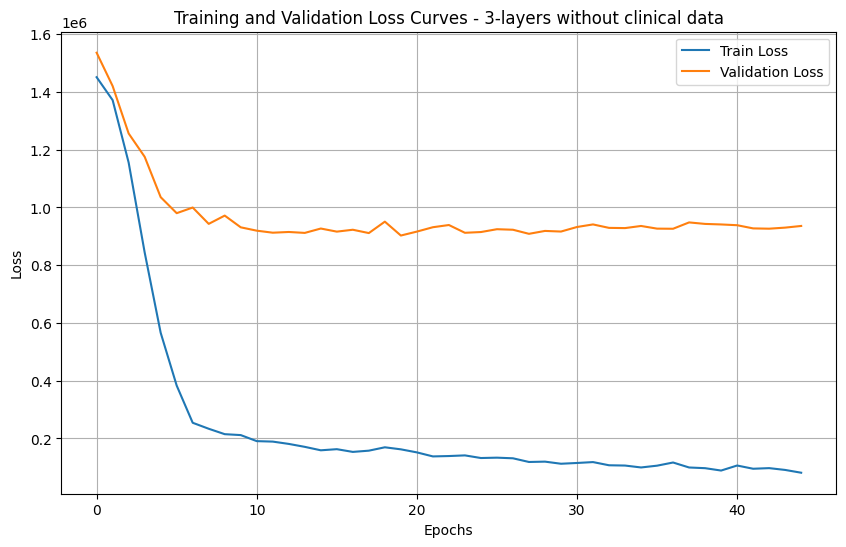

In [26]:
plot_losses_grid(best_model, "3-layers with clinical data" if WITH_CLINICAL else "3-layers without clinical data")

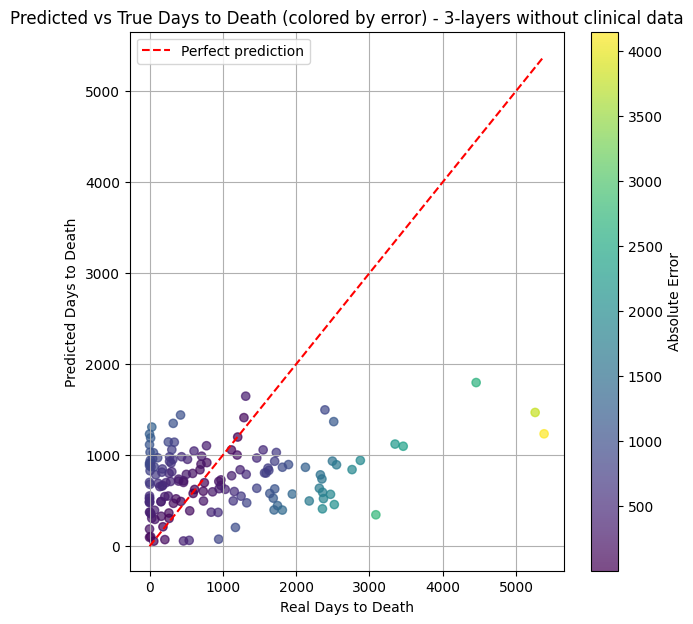

In [27]:
plot_real_vs_predicted(y_test_fixed, preds, "3-layers with clinical data" if WITH_CLINICAL else "3-layers without clinical data")

## MLP 5-layers

In [35]:
def cindex_scorer(y_true, y_pred):
    return concordance_index(y_true, -y_pred.ravel())
cindex = make_scorer(cindex_scorer, greater_is_better=True)

net = NeuralNetRegressor(
    module=Net_5layers,
    module__input_dim=X_mlp.shape[1],
    module__output_dim=1,
    max_epochs=100,
    lr=1e-3,
    batch_size=64,
    optimizer=torch.optim.AdamW,
    criterion=nn.MSELoss(),
    iterator_train__drop_last=True,  # To ensure consistent batch sizes
    callbacks=[
        ('lr_scheduler', LRScheduler(
            ReduceLROnPlateau,
            mode='min',
            factor=0.7,
            patience=10,
            monitor='valid_loss',
            min_lr=1e-6
        )),
        ('early_stopping', EarlyStopping(
            monitor='valid_loss',
            patience=20,
            threshold=1e-4,
            threshold_mode='rel',
            load_best=True
        ))
    ],
)

params = {    
    'module__hidden1': [128, 256],
    'module__hidden2': [64, 128],
    'module__hidden3': [32, 64],
    'module__hidden4': [16, 32],
    'module__dropout': [0.3, 0.5],
    'optimizer__weight_decay': [1e-6, 1e-5, 1e-4],
    'callbacks__lr_scheduler__factor': [0.7, 0.5],
    'lr': [1e-2, 1e-3],
    'batch_size': [16, 32, 64],
}

"""params = {
    'module__dropout': [0.1, 0.2, 0.3, 0.4],
    'lr': [1e-2, 5e-3, 1e-3],
    'batch_size': [32, 64, 128],
    'optimizer': [torch.optim.Adam, torch.optim.AdamW],
    'optimizer__weight_decay': [0, 1e-5, 1e-4],
    'max_epochs': [80, 100, 150],
    'callbacks__lr_scheduler__factor': [0.8, 0.6, 0.4],
    'callbacks__lr_scheduler__patience': [5, 10, 15],
    'callbacks__early_stopping__patience': [10, 20, 25],
}"""

"""params = {
    'module__dropout': [0.1],
    'lr': [5e-3],
}"""

"params = {\n    'module__dropout': [0.1],\n    'lr': [5e-3],\n}"

In [ ]:
"""rs_5 = RandomizedSearchCV(
    net,
    params,
    n_iter=50,
    scoring=cindex,
    cv=kfold,
    refit=True,
    verbose=1,
    n_jobs=1,
    random_state=SEED
)"""

rs_5 = GridSearchCV(
    estimator=net,
    param_grid=params,
    refit=True,
    cv=kfold,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=1
)

rs_5.fit(X_mlp, y_mlp.reshape(-1))

print("Best hyperparameters:", rs_5.best_params_)
print("Best C-index:", rs_5.best_score_)

best_model_5 = rs_5.best_estimator_

Fitting 15 folds for each of 50 candidates, totalling 750 fits
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1  1238624.6875  1866574.2500  0.0100  0.1388
      2  1233694.0833  1781803.2500  0.0100  0.1342
      3  1224370.8125  1691387.8750  0.0100  0.1499
      4  1216742.9792  1729420.6250  0.0100  0.1566
      5  1209355.6875  1747104.0000  0.0100  0.1315
      6  1200737.0833  1772162.1250  0.0100  0.1309
      7  1192520.4583  1792173.2500  0.0100  0.1470
      8  1183122.3333  1803332.8750  0.0100  0.1333
      9  1172496.6875  1810252.6250  0.0100  0.1226
     10  1159720.2292  1811923.7500  0.0100  0.1285
     11  1144476.3750  1809346.0000  0.0100  0.1280
     12  1128664.9583  1806052.8750  0.0100  0.1301
     13  1111969.2708  1806007.7500  0.0100  0.1319
     14  1094240.1667  1797750.8750  0.0100  0.1352
     15  1077717.7917  1807289.1250  0.0080  0.1184
     16  1063128.8125  1792385.6250  0.0080  0.1209
 

### Save best models 5-layer

In [ ]:
import joblib

if WITH_CLINICAL:
    joblib.dump(best_model, f'../models/{folder_name}/mlp_5_clinical.pkl')
else:
    joblib.dump(best_model, f'../models/{folder_name}/mlp_5_no_clinical.pkl')

#### Saving with numpy

In [ ]:
import numpy as np

net = best_model.module_

params_dict = {}
for name, param in net.named_parameters():
    params_dict[name] = param.detach().cpu().numpy()

if WITH_CLINICAL:
    np.savez(f'../models/{folder_name}/mlp_5_clinical.npz', **params_dict)
else:
    np.savez(f'../models/{folder_name}/mlp_5_no_clinical.npz', **params_dict)

### Metrics

In [50]:
preds = best_model_5.predict(X_test_mlp)
print_results(preds)

Metrics for log results:
MAE: 586.96
R²: -0.10
Preds mean/std: 665.0619 477.87155


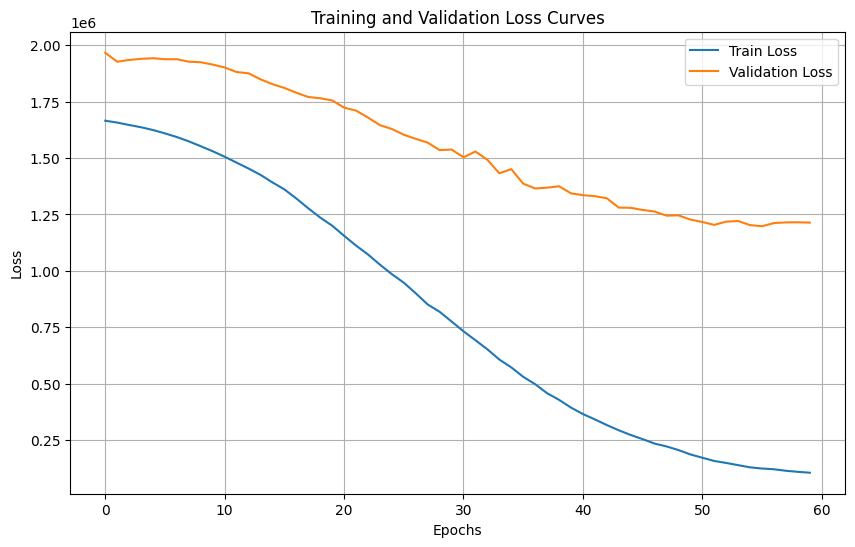

In [52]:
plot_losses_grid(best_model_5, "5-layers with clinical data" if WITH_CLINICAL else "5-layers without clinical data")

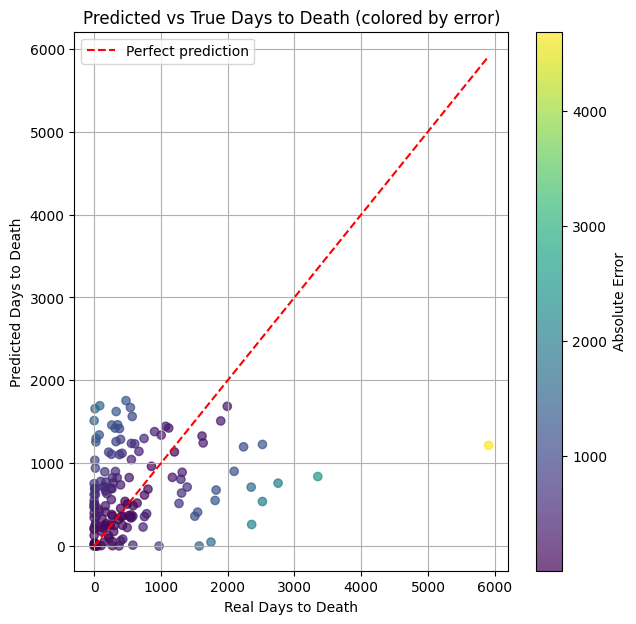

In [55]:
plot_real_vs_predicted(y_test_fixed, preds, "5-layers with clinical data" if WITH_CLINICAL else "5-layers without clinical data")

## Confidence interval for C-index

In [56]:
import numpy as np
from scipy import stats

def CI_Cindex(mean_scores, std_scores, n_folds):
    # Calculate 95% confidence interval for the best C-index
    best_idx = np.argmax(mean_scores)
    best_mean = mean_scores[best_idx]
    best_std = std_scores[best_idx]
    conf_int = stats.t.interval(
        0.95, df=n_folds-1,
        loc=best_mean,
        scale=best_std / np.sqrt(n_folds)
    )
    
    print(f"Best mean C-index: {best_mean:.4f}")
    print(f"95% CI: [{conf_int[0]:.4f}, {conf_int[1]:.4f}]")

In [57]:
mean_scores = rs.cv_results_['mean_test_score']
std_scores = rs.cv_results_['std_test_score']
n_folds = kfold.get_n_splits()

CI_Cindex(mean_scores, std_scores, n_folds)

Best mean C-index: 0.4446
95% CI: [0.4165, 0.4727]


In [59]:
mean_scores = rs_5.cv_results_['mean_test_score']
std_scores = rs_5.cv_results_['std_test_score']
n_folds = kfold.get_n_splits()

CI_Cindex(mean_scores, std_scores, n_folds)

Best mean C-index: 0.4116
95% CI: [0.3854, 0.4379]


## Complete models

Now known the best hyperparameters from grid search, we can make further analysis with complete models.

### 3-layer model

In [ ]:
class MiRNANet_3(nn.Module):
    def __init__(self, input_dim, output_dim, dropout, start_lr=0.001, lr_decay=0.3, patience=15):
        super(MiRNANet_3, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(64, 32),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(32, output_dim)
        )
        self.lr_decay = lr_decay
        self.patience = patience
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=start_lr)
        self.criterion = nn.L1Loss()
        self.scheduler = ReduceLROnPlateau(
            self.optimizer,
            mode='min',        # riduce LR quando la metrica (loss) smette di diminuire
            factor=self.lr_decay,        # dimezza il learning rate
            patience=self.patience        # aspetta 10 epoche senza miglioramenti
        )
    def forward(self, x):
        return self.model(x)   
    def loop(self, train_loader, test_loader, epochs=100):
        train_losses = []
        val_losses = []
        train_accs = []
        val_accs = []
        for epoch in range(epochs):
            self.model.train()
            total_train_loss = 0
            total_train_acc = 0
            for X_batch, y_batch in train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(X_batch)
                loss = self.criterion(outputs, y_batch)
                loss.backward()
                self.optimizer.step()
                total_train_loss += loss.item()
                total_train_acc += accuracy_score(np.argmax(outputs.detach().numpy(), axis=1), np.argmax(y_batch, axis=1))
            
            avg_train_loss = total_train_loss / len(train_loader)
            avg_train_acc = total_train_acc / len(train_loader)
            
            self.scheduler.step(avg_train_loss)

            train_accs.append(avg_train_acc)

            self.model.eval()
            total_val_loss = 0
            total_val_acc = 0
            with torch.no_grad():
                preds = []
                trues = []
                for X_batch, y_batch in test_loader:
                    outputs = self.model(X_batch)
                    loss = self.criterion(outputs, y_batch)
                    preds.append(outputs.numpy())
                    trues.append(y_batch.numpy())
                    total_val_loss += loss.item()
                    total_val_acc += accuracy_score(np.argmax(outputs.detach().numpy(), axis=1), np.argmax(y_batch, axis=1))
                preds = np.vstack(preds)
                trues = np.vstack(trues)
            avg_val_loss = total_val_loss / len(test_loader)
            avg_val_acc = total_val_acc / len(test_loader)

            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)

            val_accs.append(avg_val_acc)

            print(f"Epoch {epoch+1:03d}:\nTrain Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}\nTrain Acc: {avg_train_acc:.4f} | Val Acc: {avg_val_acc:.4f}")
            mae = mean_absolute_error(trues, preds)
            print(f"Test MAE: {mae:.2f}")

        model_res = {
            'params':self.model.parameters(),
            'train_losses':train_losses,
            'eval_losses': val_losses,
            'train_accs': train_accs,
            'val_accs':val_accs,
            'preds':preds,
            'trues':trues
        }

        return model_res

### 5-layer model

In [ ]:
class MiRNANet_5(nn.Module):
    def __init__(self, input_dim, output_dim, dropout):#, start_lr = 0.001):
        super(MiRNANet_5, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            
            nn.Linear(128, output_dim)  # <--- ultimo layer lineare
        )
        self.optimizer = torch.optim.Adam(self.model.parameters())#, lr=start_lr)
        self.criterion = nn.MSELoss()
        self.scheduler = ReduceLROnPlateau(
            self.optimizer,
            mode='min',        # riduce LR quando la metrica (loss) smette di diminuire
            factor=0.6,        # dimezza il learning rate
            patience=15        # aspetta 10 epoche senza miglioramenti
        )
    def forward(self, x):
        return self.model(x)
    
    def loop(self, train_loader, test_loader, epochs=100):
        train_losses = []
        val_losses = []
        for epoch in range(epochs):
            self.model.train()
            total_train_loss = 0
            for X_batch, y_batch in train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(X_batch)
                # print(outputs)
                loss = self.criterion(outputs, y_batch)
                loss.backward()
                self.optimizer.step()
                total_train_loss += loss.item()
            
            avg_train_loss = total_train_loss / len(train_loader)
            self.scheduler.step(avg_train_loss)

            self.model.eval()
            total_val_loss = 0
            with torch.no_grad():
                preds = []
                trues = []
                for X_batch, y_batch in test_loader:
                    outputs = self.model(X_batch)
                    loss = self.criterion(outputs, y_batch)
                    preds.append(outputs.numpy())
                    trues.append(y_batch.numpy())
                preds = np.vstack(preds)
                trues = np.vstack(trues)
                total_val_loss += loss.item()
            avg_val_loss = total_val_loss / len(test_loader)

            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)

            print(f"Epoch {epoch+1:03d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        model_res = {
            'params':self.model.parameters(),
            'train_losses':train_losses,
            'eval_losses': val_losses
        }

        return model_res